Food image classification using the Fast AI library and the Food-101 dataset
=====
The purpose of this notebook is to create a deep learning model to classify images using the Fast AI library and the Food-101 dataset. The Fast AI under the hood uses the PyTorch library. The created model will try to get close to matching some recent [state of the art results](https://arxiv.org/pdf/1612.06543.pdf) and have a target of >85% for top-1 accuracy. 

Dataset:  
https://www.vision.ee.ethz.ch/datasets_extra/food-101/ 

Libraries used:  
https://docs.fast.ai/  
https://pytorch.org/


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *


Set parameters here:

The initial batch size used is 64 for 224x224 images. ResNet-50 model is used as a starting point for the transfer learning process.

In [3]:
bs = 64
arch = models.resnet50

img_size = 224

Grab the dataset - uncomment the line to actually download the dataset and untar it

In [4]:
path = Path('data')
dataset_url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
#untar_data(dataset_url, 'food-101.tar.gz', path)

In [5]:
path = Path('data/food-101') #untar creates food-101 subdirectory
path_img = path/'images'


## Food-101 dataset
The Food-101 dataset has 101 food categories, with 1000 images provided for each category for a total of 101,000 images. The Food-101 dataset provides a list of examples for training as well as another list for testing. Since the dataset specifies an equal amount of examples for each category, we do not need to worry about class imbalances. For each category, 250 images are in the test set and 750 for the training set. The training set is split into 20% for the validation set and 80% for the training set. 

Training set: 60600 images  
Validation set: 15150 images  
Test set: 25250 images  

The validation set is used to check the performance of the model after each training epoch. The test set is evaluated only once at the end of this notebook to provide an accuracy score. 

The examples for each category are located in subdirectories with the category names. The file list is treated like a csv file, though now delimited with a '/' symbol. This is read using Pandas into a Pandas DataFrame structure and then is modified so that the paths and .jpg file extensions are added. Fast AI provides a way of reading the DataFrame structure and we need to note that the labels are in column 0 and the examples are in column 1. 

The images are resized to 224x224 for faster training of the model. Data augmentation during training uses the default set of transforms provided by the Fast AI library as well as the default parameters. These are provided by the get_transforms() method. Since it's difficult to see what parameters and transforms are used from this method, the extracted list and parameters are provided below(ds_tfms). The pixel values of the examples are also normalized based on the ImageNet values. These examples could have been normalized by determining the mean & standard deviation of this specific dataset, but it appears that the ImageNet values were sufficient for a good result. 

In [6]:
train_path = 'data/food-101/meta/train.txt'
test_path = 'data/food-101/meta/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])


data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .random_split_by_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


Let's visualize some examples in the dataset - these are with transformations applied:

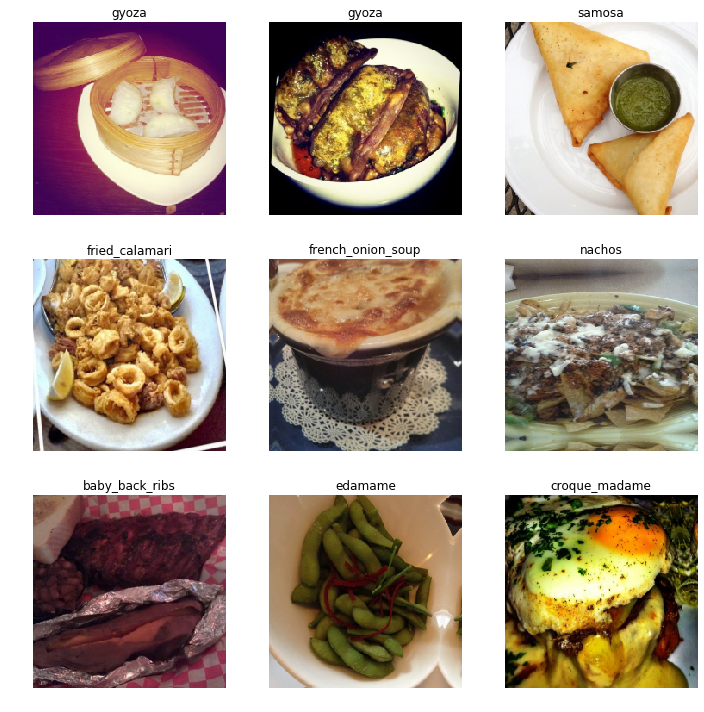

In [30]:

data.show_batch(rows=3, figsize=(10, 10))

Here's a list of the classes. It can be verified that there are 101 classes.

In [8]:
print(data.classes);
print(data.c)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

For metrics, we will look at the accuracy(top-1) and the top-5 accuracy(notated as top_k_accuracy). ResNet-50 and the its weights are used as a starting point for transfer learning. ResNet-50 is selected as it is a fairly  The Fast AI library then discards the classfication layer of the ResNet-50 model and then attaches a few additional layers. More information can be found [in the fastai documentation](https://docs.fast.ai/vision.learner.html#create_cnn)

In [9]:
top_5 = partial(top_k_accuracy, k=5)

learn = create_cnn(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)


Learning rate has a great impact on training the model. If the learning rate is too large, the loss will diverge - if it is too small, then it will take a very long time to train the model. We use the fastai learning rate finder to see what is a good starting point for a learning rate. We find the point where at the greatest negative slope. 

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02


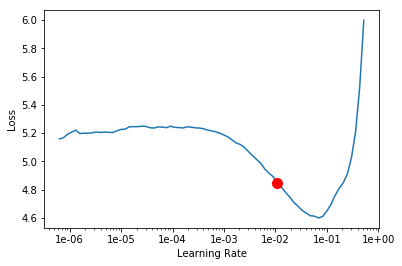

In [11]:
learn.recorder.plot(suggestion=True)


We train the model for 5 epochs at a time, occasionally varying the learning rate.

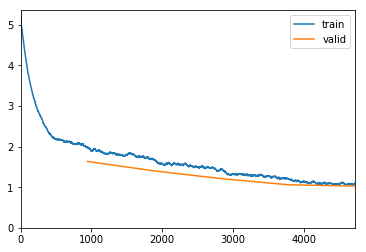

In [12]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))
learn.save('food-101-test-e5')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


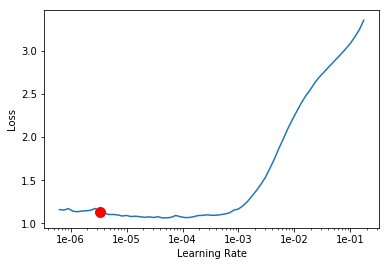

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

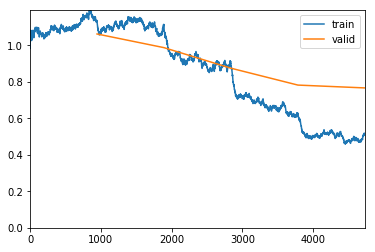

In [14]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-test-e10')

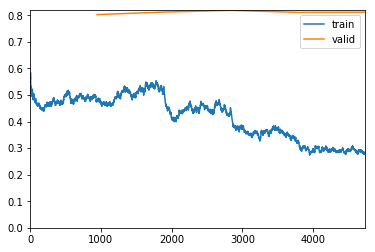

In [15]:

learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e15')

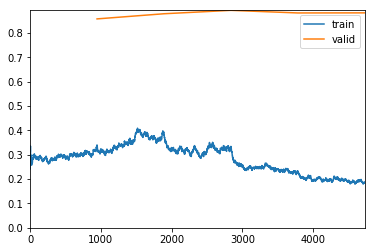

In [16]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e20')

So far we have been training at 224x224. Let's switch to 512x512 to increase the accuracy. Although we train to 35 epochs, it seems like the desired accuracy on the validation set is reached at 25 epochs. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


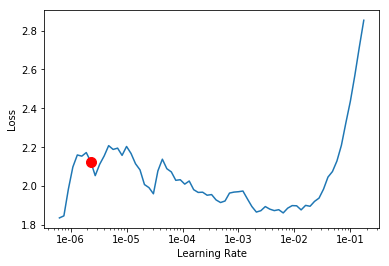

In [28]:
bs=16
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .random_split_by_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=512)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = create_cnn(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)
learn.load('food-101-test-e20')

learn.lr_find()
learn.recorder.plot(suggestion=True)


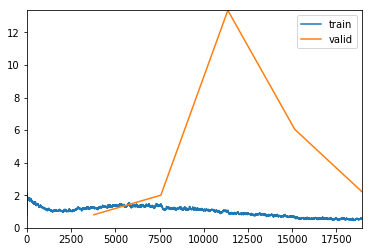

In [29]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-2))
learn.save('food-101-test-e25-512')

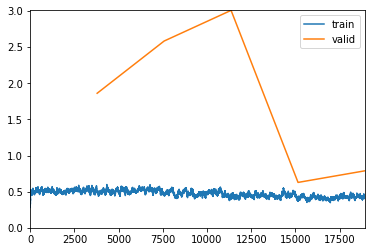

In [30]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-8, 1e-3))
learn.save('food-101-test-e30-512')

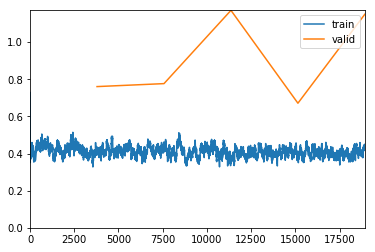

In [31]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-9, 1e-4))
learn.save('food-101-test-e35-512')

We can visually look at some of the mispredictions and see if there is any conclusion that can be drawn from them. fastai has built in functions to display examples based on top losses, high/low probability. The confusion matrix is also useful to see what is commonly misclassified.

In [32]:
interp = ClassificationInterpretation.from_learner(learn)


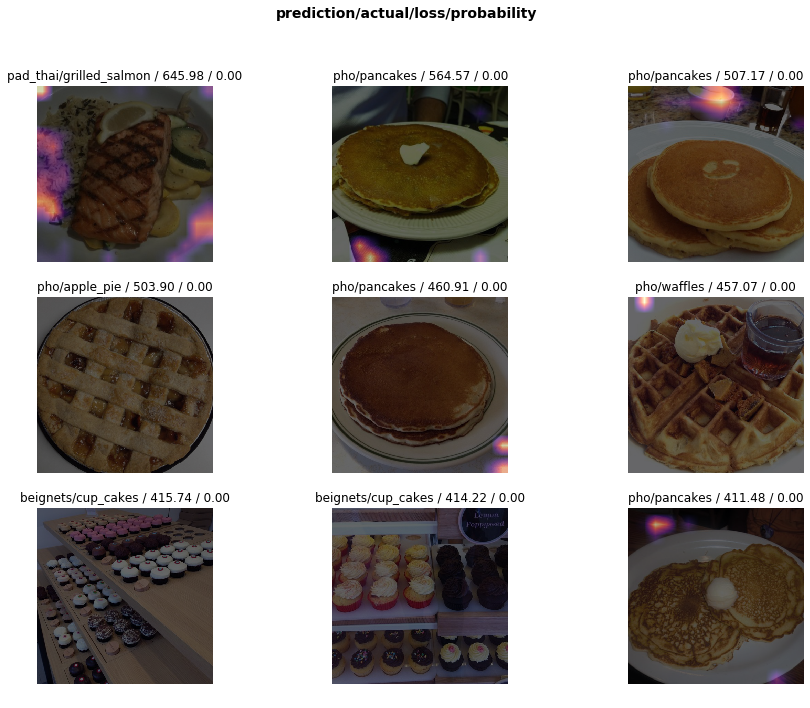

In [33]:
interp.plot_top_losses(9, figsize=(15, 11))


In [34]:
interp.most_confused(min_val=5)

[('steak', 'filet_mignon', 26),
 ('steak', 'pork_chop', 19),
 ('pancakes', 'pho', 17),
 ('filet_mignon', 'steak', 16),
 ('chocolate_cake', 'chocolate_mousse', 15),
 ('dumplings', 'gyoza', 15),
 ('chocolate_mousse', 'chocolate_cake', 14),
 ('beef_tartare', 'tuna_tartare', 13),
 ('steak', 'prime_rib', 12),
 ('prime_rib', 'steak', 11),
 ('apple_pie', 'bread_pudding', 10),
 ('bread_pudding', 'apple_pie', 10),
 ('cheesecake', 'panna_cotta', 10),
 ('steak', 'baby_back_ribs', 10),
 ('tuna_tartare', 'ceviche', 10),
 ('chocolate_mousse', 'tiramisu', 9),
 ('french_toast', 'bread_pudding', 8),
 ('pork_chop', 'baby_back_ribs', 8),
 ('ravioli', 'lasagna', 8),
 ('sushi', 'sashimi', 8),
 ('cheesecake', 'strawberry_shortcake', 7),
 ('ice_cream', 'chocolate_mousse', 7),
 ('ice_cream', 'frozen_yogurt', 7),
 ('panna_cotta', 'chocolate_mousse', 7),
 ('panna_cotta', 'tiramisu', 7),
 ('pork_chop', 'steak', 7),
 ('baklava', 'apple_pie', 6),
 ('breakfast_burrito', 'huevos_rancheros', 6),
 ('chicken_quesadilla

15109 misclassified samples over 15150 samples in the validation set.


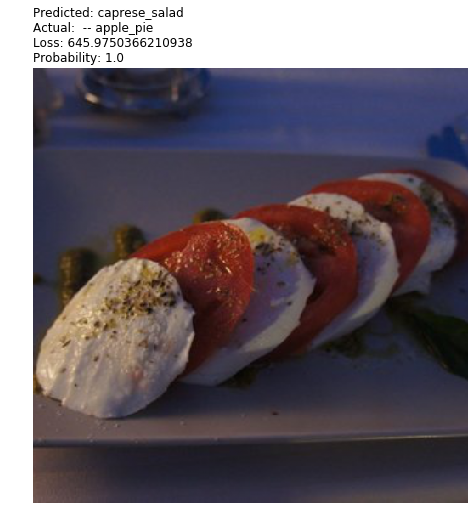

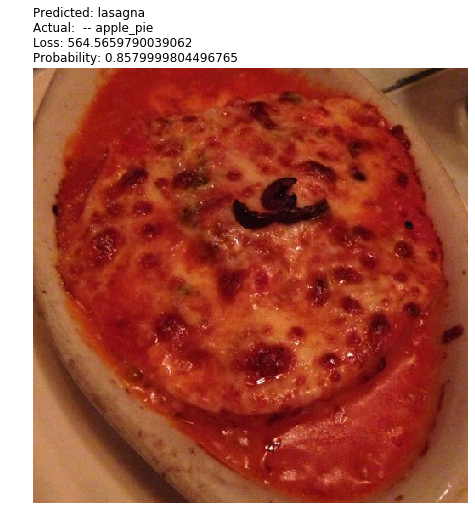

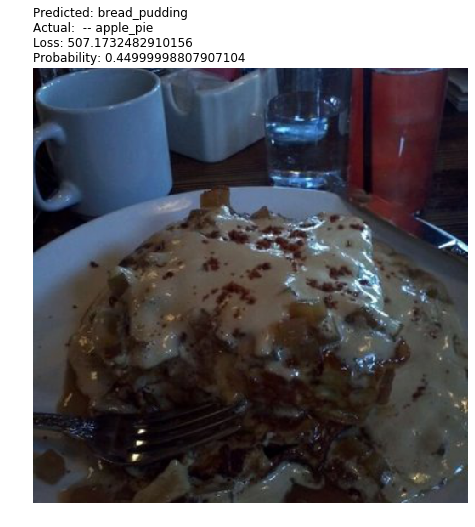

In [35]:
interp.plot_multi_top_losses()

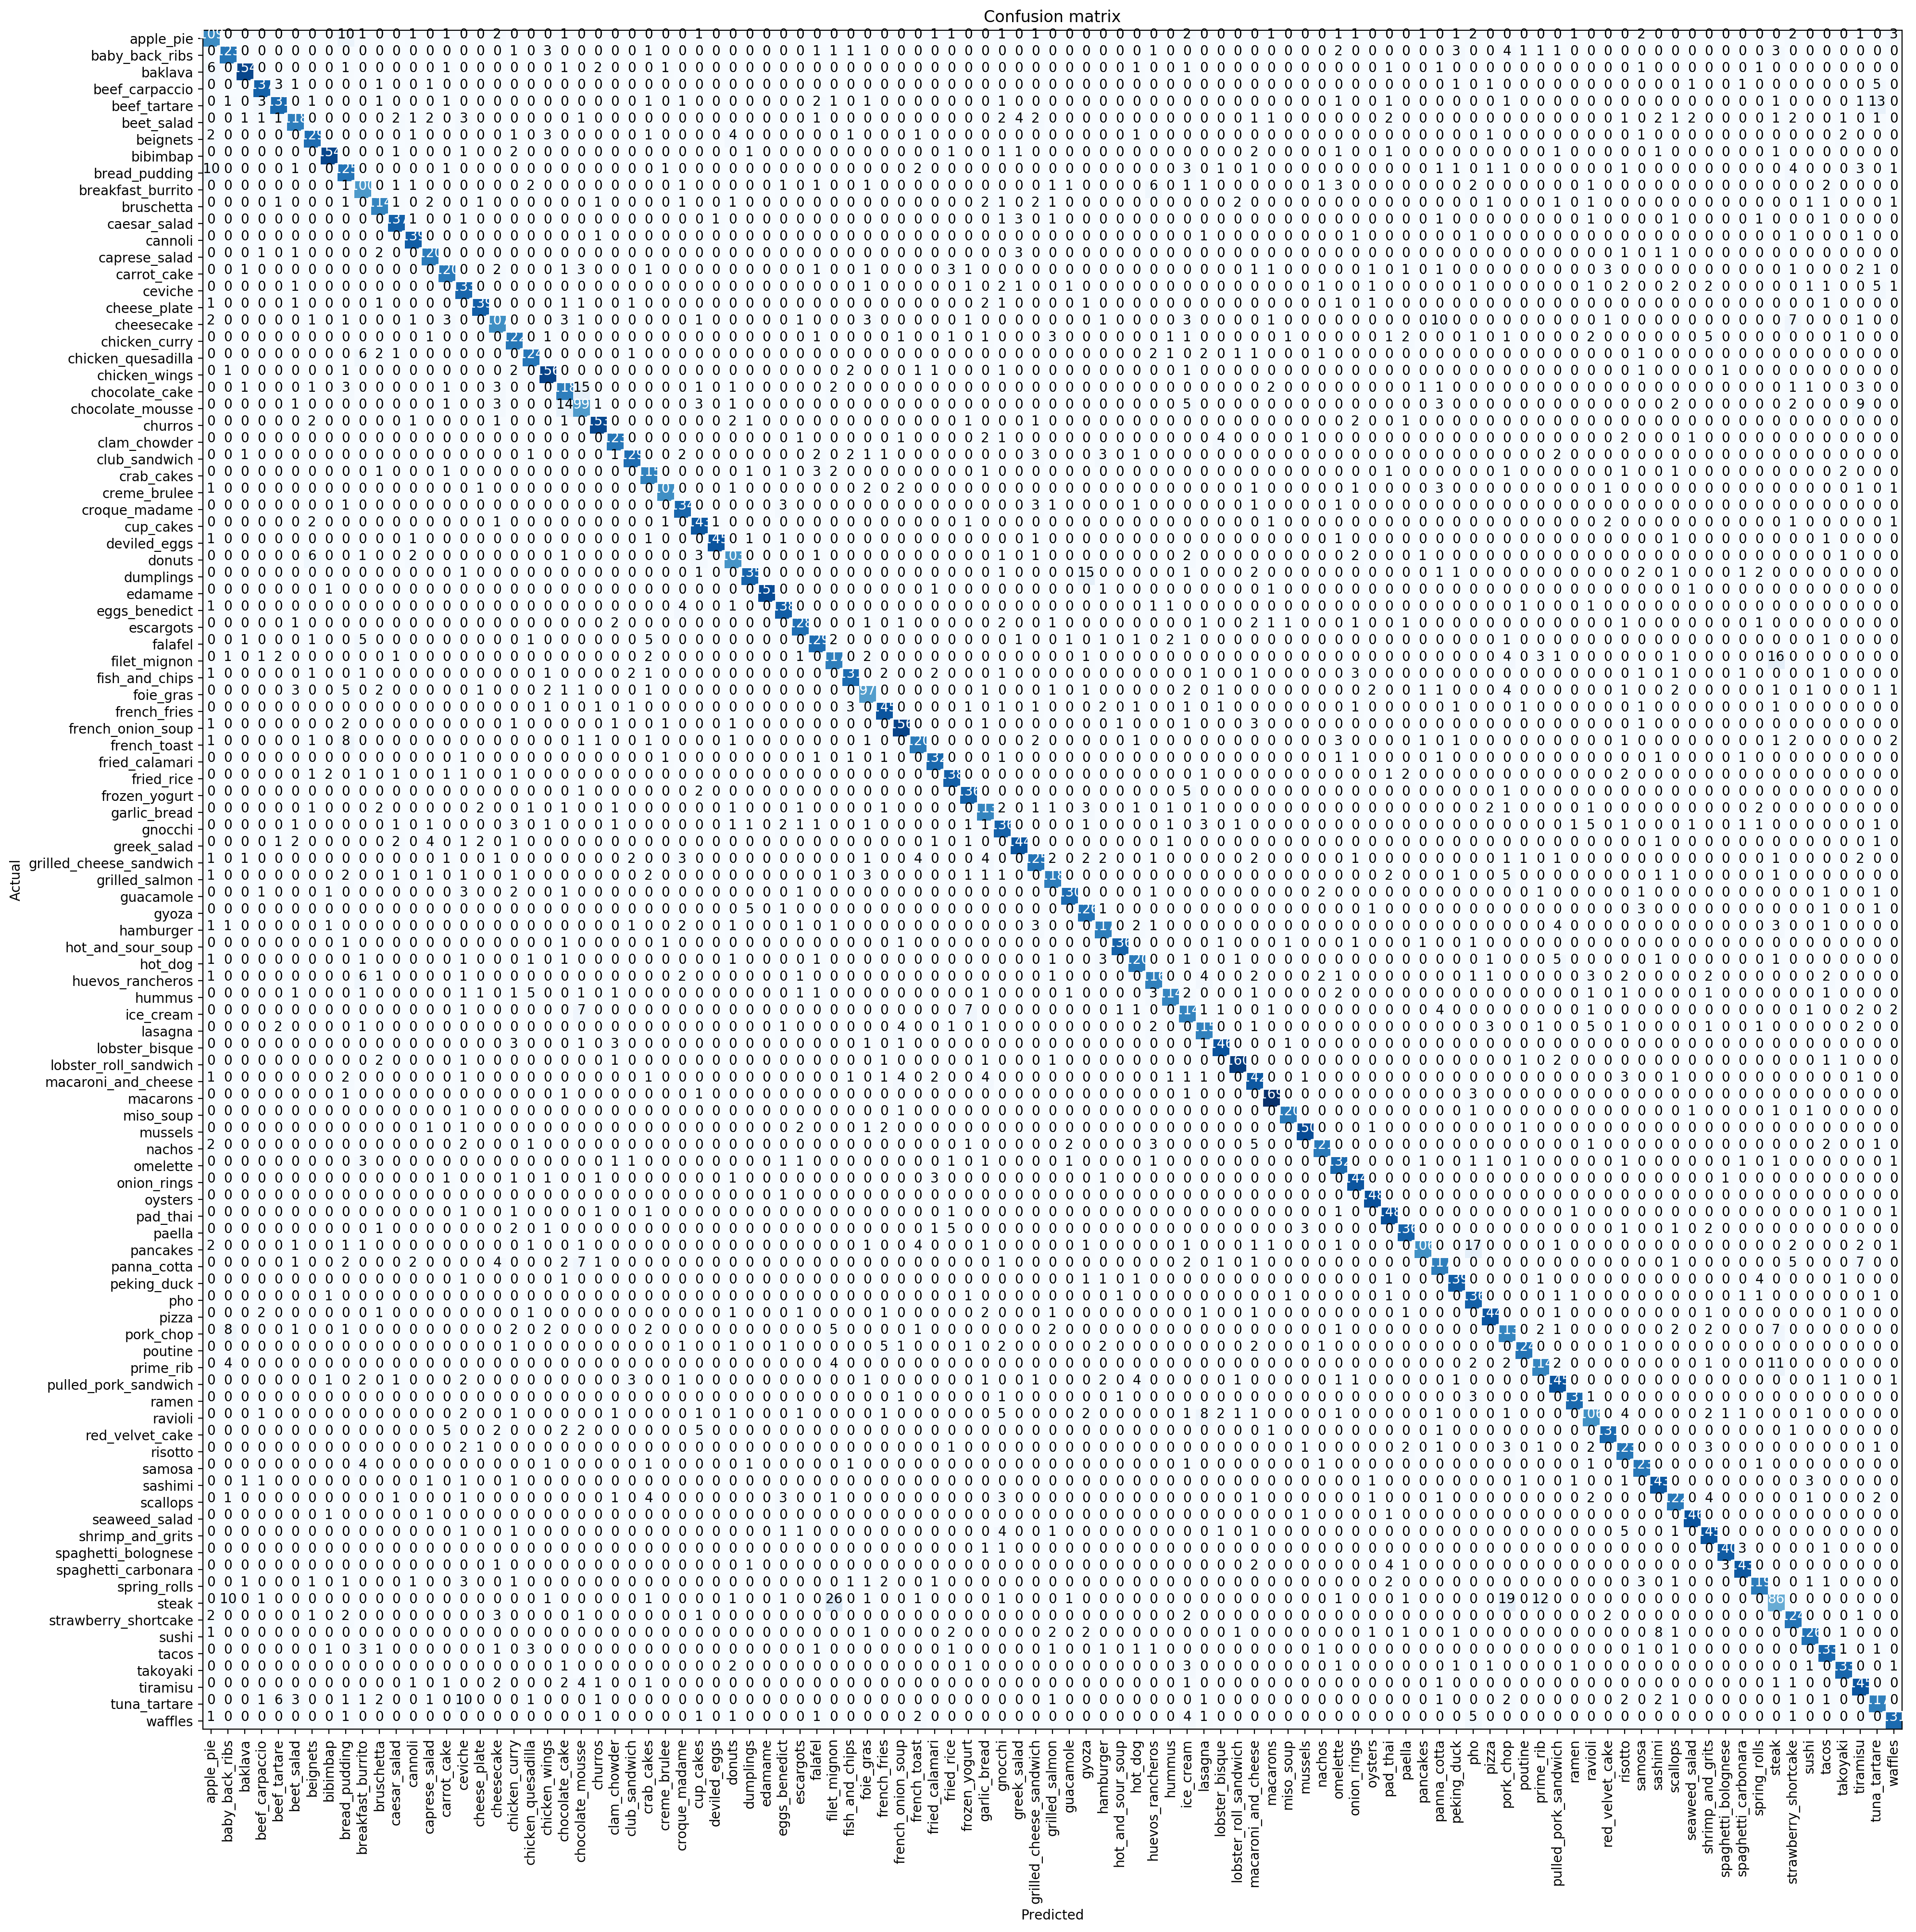

In [36]:
interp.plot_confusion_matrix(figsize=(20, 20), dpi=200)

Let's load the test set and evaluate using the model above. 

In [28]:
bs=16
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .no_split()
            .label_from_df(cols=0)
            .transform(size=512)
            .databunch(bs=bs)
            .normalize(imagenet_stats))


learn = create_cnn(test_data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)
learn.load('food-101-test-e30-512')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: data/food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [29]:
learn.validate(test_data.train_dl)

[0.8643152, tensor(0.8744), tensor(0.9737)]

### Analysis

Based on the validation set, we can see a find some of the most misclassified items in the confusion matrix:

- filet mignon and steak
- pork chop and steak
- pancakes and pho
- chocolate cake and chocolate mousse
- dumplings and gyoza

#### Similar categories 
Since filet mignon is a type of steak and gyoza is the Japanese word for dumpling, the classification between the two categories cannot be easily determined. In some examples, chocolate mousse cake does look like chocolate cake. Perhaps the categories could have been created to be more distinct. For a fixed dataset like Food-101, we can do little in our model to compensate for this. 

#### True misclassified examples
For pancakes and pho, these are true mispredictions since they are not similar to the human eye. Pork chops and steak are more similar, but a human eye could be able to determine the difference between the two. Some more image transformations could help the model distinguish the differences. 


#### Mislabeled examples
Some of the examples are mislabeled. Based on the run of plot_multi_top_losses() above, which we can see that some of the mislabeled examples had the highest losses and highest probability of being the predicted category. We see that the labeled apple_pie image is actually a caprese_salad, the 2nd apple_pie image is actually a lasagna. The 3rd image of the apple_pie is predicted as bread_pudding - although this would be less certain for a human classifying this image. Because the dataset has mislabeled examples - there is an upper bound on the accuracy of the results - we know that 100% will not be possible. For the most part, the model is able to generalize with these mislabeled examples. 


#### Other notes on the dataset
In addition to the mislabeled examples, we see that there is quite a range of brightness and contrast through the dataset. This is meant to model actual photos that would be captured in a variety of lighting in restaurant  environments. 

#### Metrics
Top-1 and Top-5 are used for evaluating the model as they are also used in recent [food recognition papers](https://arxiv.org/pdf/1612.06543.pdf). 


#### Results on the test set:
The test set is evaluated above on a model that has been trained on 30 epochs:  
Top-1 87.44%   
Top-5 97.37%  

We meet our goal of >85% for Top-1 accuracy, but we don't quite meet the state of the art results of 89.58% from WISeR. 


#### Possible improvements
1. Only basic transformations were used in this model. Possible enhancements would be to try other augmentations like jitter or skew. Also, the brightness and contrast parameters would be tuned for a higher range. This might help with separating food that had a similar color, but different shapes - or similar shapes with different colors. 
2. Test time augmentation could be used - This is test time, several augmentations are used on the test set to create several predictions for each test example. The results are then combined to provide one result. 
3. A deeper ResNet model could be used to improve the result at the cost of the size of a larger model and more computation time. 

